In [1]:
import os, math, saxpy
import numpy as np
import pandas as pd

from scipy import signal

os.chdir('/home/atom/cvlab/thesis/')
print(os.getcwd())

/home/atom/cvlab/thesis


# Load Data

In [2]:
from dataset.dataset import JumpPoseDataset

pose_paths = './dataset/marker_data'
info_path = './dataset/info.xlsx'
dataset = JumpPoseDataset(pose_paths, info_path, mode='vector')
poses, labels = zip(*dataset)
labels = np.asarray([int(l[0]) for l in labels])

# Randomized Time Warping

In [3]:
def TERMS(vec, k, Z):
    """
    Sample k-length Z times
    """
    TE = np.array([vec[sorted(np.random.randint(len(vec), size=k))] for _ in range(Z)])
    return TE
    
# example usage
pose = poses[0]
print(f'Shape of original pose is {pose.shape}')

TE = TERMS(pose, 5, 10)
print(f'Shape of TE features with k=5, Z=10 is {TE.shape}')

Shape of original pose is (1137, 87)
Shape of TE features with k=5, Z=10 is (10, 5, 87)


# Algorithm 1.

In [101]:
from itertools import product

# set hyperparams
k, Z = 100, 50

classes = [0, 1]
D_len = len(dataset)
C_len = len(classes)

R = [np.zeros((len(labels[np.where(labels==c)]),k,k)) for c in classes]
Y = [np.zeros((len(labels[np.where(labels==c)]),k,k)) for c in classes]

Rc = [np.zeros((k,k)) for _ in range(C_len)]
Mc = [np.zeros((k,k)) for _ in range(C_len)]

for c in classes:
    for i, j in zip(range(len(np.where(labels==c)[0])), np.where(labels==c)[0]):
        x = poses[j]

        # Obtain TE features
        s = TERMS(x, k, Z)

        # Calculate set covariance
        R[c][i] = np.apply_over_axes(lambda a, b: a[b]@a[b].T, axes=[0], a=s).mean(axis=0) 

        # Apply eigendecomposition
        w, Y[c][i] = np.linalg.eig(R[c][i]) # after resorting via argsort, w and Y[i] don't correspond
        Y[c][i] = Y[c][i][w.argsort()[::-1]] # order eigenvectors by eigenvalues. Large to small
    
    Rc[c] = np.apply_over_axes(lambda a, b: a[b]@a[b].T, axes=[0], a=s).mean(axis=0) # shape (k, k)
    w, Mc[c] = np.linalg.eig(Rc[c]) 
    Mc[c] = Mc[c][w.argsort()[::-1]]

# obtain GDS and principal subspace
P, H = np.linalg.eig(np.apply_over_axes(lambda x, y: x[y]@x[y].T, axes=[0], a=s).mean(axis=0)) 

# project all subspaces onto the GDS
for c in classes:
    for i in range(len(np.where(labels==c)[0])):
        Y[c][i] = H.T @ Y[c][i]    
        
# format Y for next stage
Y = np.append(Y[0],Y[1], axis=0)

/home/atom/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: ComplexWarning: Casting complex values to real discards the imaginary part
/home/atom/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: ComplexWarning: Casting complex values to real discards the imaginary part


In [102]:
import torch
from itertools import permutations
from souza_tools import *

# generate similarity matrix
K = torch.zeros((D_len, D_len))
for q, w in product(range(D_len), range(D_len)):
    K[q,w] = similarity_matrix(torch.tensor(Y[q]),torch.tensor(Y[w]))

In [103]:
import scipy

c_blocks = []
for c in classes:
    c_len = len(np.where(labels==c)[0])
    c_blocks.append(np.ones((c_len,c_len)))
    
V = torch.tensor(scipy.linalg.block_diag(*c_blocks))
I = torch.eye(len(V))

S_b = K @ (V - torch.ones(V.shape) / len(V)).float() @ K
S_w = K @ (I - V).float() @ K

sig = 1

# solve LDA problem
w, a = torch.eig(torch.inverse(S_w + sig**2 * I) @ S_b, eigenvectors=True)

# compute training coefficients
F = a * K

In [104]:
F_test

tensor(0.2550)

# Algorithm 2

In [105]:
Y[q].dtype, X.real.dtype

(dtype('float64'), dtype('float64'))

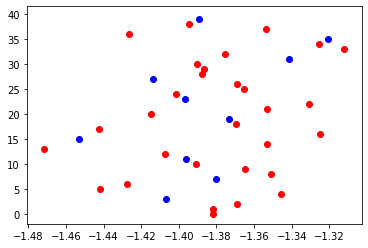

In [111]:
i = 1
for i in range(40):
    x = poses[i]
    y = labels[i]

    # Obtain TE features
    s = TERMS(x, k, Z)

    # Calculate set covariance
    R = np.apply_over_axes(lambda a, b: a[b]@a[b].T, axes=[0], a=s).mean(axis=0) 

    # Apply eigendecomposition
    w, X = np.linalg.eig(R) # after resorting via argsort, w and Y[i] don't correspond
    X = X[w.argsort()[::-1]] # order eigenvectors by eigenvalues. Large to small

    # project all subspaces onto the GDS
    X = H.T @ X  
    
    # generate similarity matrix
    K_test = torch.zeros(D_len)
    for q in product(range(D_len)):
        K_test[q] = similarity_matrix(torch.tensor(Y[q].real),torch.tensor(X.real))

    # compute test coefficents
    F_test = a[0].T @ K_test
    
    if y:
        plt.scatter(a[0].T @ K_test, i, color='r')
    else:
        plt.scatter(a[0].T @ K_test, i, color='b')

plt.show()

In [94]:
K_test

tensor([1.2311, 1.2006, 1.2797, 1.2271, 1.2505, 1.2402, 1.2464, 1.2661, 1.2729,
        1.2850, 1.1957, 1.2460, 1.2387, 1.2382, 1.2572, 1.1856, 1.3436, 1.1483,
        1.2498, 1.1955, 1.2786, 1.2902, 1.1440, 1.2295, 1.1737, 1.4077, 1.3375,
        1.1770, 1.1260, 1.2047, 1.2053, 1.2168, 1.1868, 1.2115, 1.2873, 1.2404,
        1.2000, 1.2220, 1.2653, 1.6603])

In [14]:
%matplotlib qt

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

a = np.random.random(size=(40,3))
b = np.random.multivariate_normal([1,1,1], [[0.01,0,0],[0,0.5,0], [0,0,1]], size=40)
X = np.concatenate((a,b))
y = np.concatenate((np.zeros(len(a)), np.ones(len(b))))

ax.scatter(*a.T, c='blue')
ax.scatter(*b.T, c='red')

ax.scatter(*a.mean(axis=0).T, marker='*', c='blue', s=150)
ax.scatter(*b.mean(axis=0).T, marker='*', c='red', s=150)

def comp_mean_vectors(X, y):
    class_labels = np.unique(y)
    n_classes = class_labels.shape[0]
    mean_vectors = []
    for cl in class_labels:
        mean_vectors.append(np.mean(X[y==cl], axis=0))
    return mean_vectors

def scatter_within(X, y):
    class_labels = np.unique(y)
    n_classes = class_labels.shape[0]
    n_features = X.shape[1]
    mean_vectors = comp_mean_vectors(X, y)
    S_W = np.zeros((n_features, n_features))
    for cl, mv in zip(class_labels, mean_vectors):
        class_sc_mat = np.zeros((n_features, n_features))                 
        for row in X[y == cl]:
            row, mv = row.reshape(n_features, 1), mv.reshape(n_features, 1)
            class_sc_mat += (row-mv).dot((row-mv).T)
        S_W += class_sc_mat                           
    return S_W

def scatter_between(X, y):
    overall_mean = np.mean(X, axis=0)
    n_features = X.shape[1]
    mean_vectors = comp_mean_vectors(X, y)    
    S_B = np.zeros((n_features, n_features))
    for i, mean_vec in enumerate(mean_vectors):  
        n = X[y==i+1,:].shape[0]
        mean_vec = mean_vec.reshape(n_features, 1)
        overall_mean = overall_mean.reshape(n_features, 1)
        S_B += n * (mean_vec - overall_mean).dot((mean_vec - overall_mean).T)
    return S_B

SW, SB = scatter_within(X,y), scatter_between(X,y)
SWa, SWb = scatter_within(X[:40],y[:40])/4, scatter_within(X[40:],y[40:]) /4

origin = [0], [0]
ax.quiver(*a.mean(axis=0).T, SWa[:,0], SWa[:,1], SWa[:,2], color='skyblue')
ax.quiver(*b.mean(axis=0).T, SWb[:,0], SWb[:,1], SWb[:,2], color='pink')

plt.show()

eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(SW).dot(SB))
eig_vals, eig_vecs
eig_vecs = eig_vecs[eig_vals.argsort()[::-1]]

W = np.hstack((eig_vecs[0].reshape(3,1)))

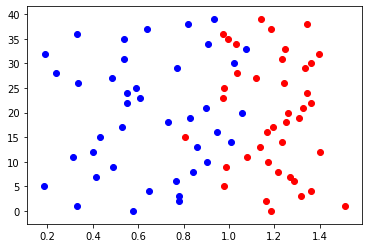

In [21]:
%matplotlib inline

def get_components(eig_vals, eig_vecs, n_comp=1):
    n_features = X.shape[1]
    eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]
    eig_pairs = sorted(eig_pairs, key=lambda k: k[0], reverse=True)
    W = np.hstack([eig_pairs[i][1].reshape(3, 1) for i in range(0, n_comp)])
    return W

a_lda = a @ get_components(eig_vals, eig_vecs)
b_lda = b @ get_components(eig_vals, eig_vecs)

plt.scatter(a_lda, range(len(a)), c='blue')
plt.scatter(b_lda, range(len(a)), c='red')
plt.show()

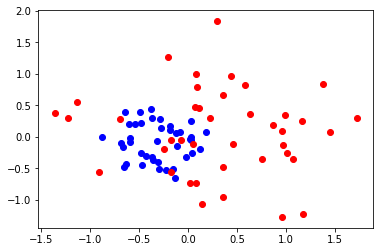

In [22]:
from sklearn.decomposition import PCA

clf = PCA(n_components=2)
clf.fit(np.concatenate((a,b)), np.concatenate((np.zeros(len(a)), np.ones(len(b)))))

plt.scatter(*clf.transform(a).T, color='blue')
plt.scatter(*clf.transform(b).T, color='red')

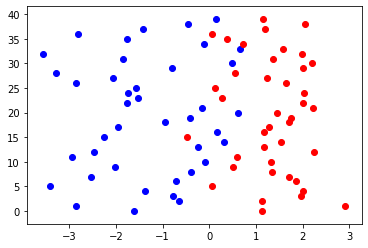

In [23]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

clf = LDA(n_components=1, store_covariance=True)
clf.fit(np.concatenate((a,b)), np.concatenate((np.zeros(len(a)), np.ones(len(b)))))

plt.scatter(clf.transform(a), range(len(a)),color='blue')
plt.scatter(clf.transform(b), range(len(b)),color='red')
plt.show()

In [ ]:
a.shape